In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans

from sklearn.model_selection import KFold
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

/home/itachi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.drop('dropoff_datetime', axis=1, inplace=True)

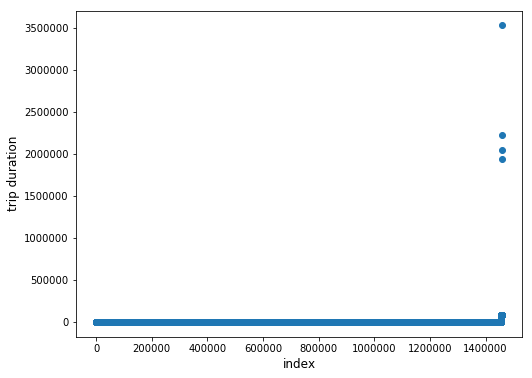

Time =>  0:00:18.467448


In [4]:
import datetime
start = datetime.datetime.now()

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train['trip_duration']))
plt.xlabel('index', fontsize=12)
plt.ylabel('trip duration', fontsize=12)
plt.show()

end = datetime.datetime.now()
print("Time => " , end-start)

In [5]:
train[train['trip_duration'] > 1500000]

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
355003,id1864733,1,2016-01-05 00:19:42,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736
680594,id0369307,1,2016-02-13 22:38:00,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578
924150,id1325766,1,2016-01-05 06:14:15,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612
978383,id0053347,1,2016-02-13 22:46:52,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282


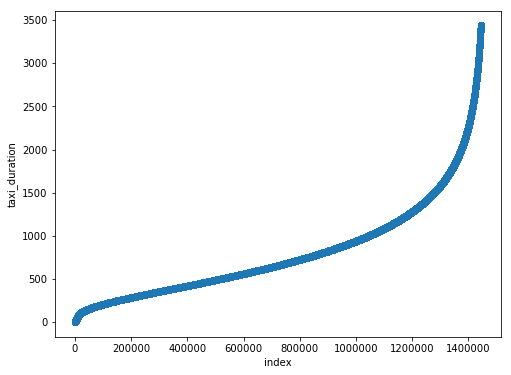

In [6]:
q = train['trip_duration'].quantile(.99)
train = train[train['trip_duration'] < q]
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train['trip_duration']))
plt.xlabel('index')
plt.ylabel('taxi_duration')
plt.show()

In [7]:
train["trip_duration"] = np.log(train["trip_duration"])

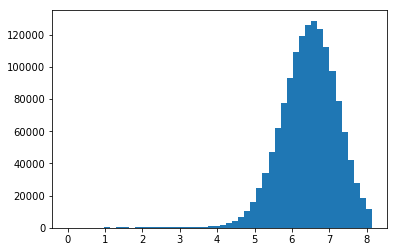

In [8]:
plt.hist(train["trip_duration"], bins=50)
plt.show()

In [9]:
print(train.shape, test.shape)
data = pd.concat([train,test],axis=0)

(1444051, 10) (625134, 9)


In [10]:
data.loc[:,'pickup_datetime'] = data.loc[:,'pickup_datetime'].apply(pd.Timestamp)

In [11]:
data.head()

,dropoff_latitude,dropoff_longitude,id,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,store_and_fwd_flag,trip_duration,vendor_id
0,40.765602,-73.964630,id2875421,1,2016-03-14 17:24:55,40.767937,-73.982155,N,6.120297,2
1,40.731152,-73.999481,id2377394,1,2016-06-12 00:43:35,40.738564,-73.980415,N,6.496775,1
2,40.710087,-74.005333,id3858529,1,2016-01-19 11:35:24,40.763939,-73.979027,N,7.661056,2
3,40.706718,-74.012268,id3504673,1,2016-04-06 19:32:31,40.719971,-74.010040,N,6.061457,2
4,40.782520,-73.972923,id2181028,1,2016-03-26 13:30:55,40.793209,-73.973053,N,6.075346,2


In [12]:
data.loc[:,'month'] = data.loc[:,'pickup_datetime'].dt.month
data.loc[:,'week_of_theyear'] = data.loc[:,'pickup_datetime'].dt.weekofyear
data.loc[:,'week_day'] = data.loc[:,'pickup_datetime'].dt.weekday
data.loc[:,'hour'] = data.loc[:,'pickup_datetime'].dt.hour
data.loc[:,'minute'] = data.loc[:,'pickup_datetime'].dt.minute
data.loc[:,'second'] = data.loc[:,'pickup_datetime'].dt.second
# Count trips over 60min
df_counts = data.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling('60min').count()['id']
data = data.merge(df_counts, on='id', how='left')

In [13]:
def haversine(lat1, lng1, lat2, lng2, radius=6371):
    
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    delta1 = (lat2 - lat1)
    delta2 = np.radians(lng2 - lng1)
    
    a = np.sin(delta1 / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta2 / 2)**2
    
    c = 2 * np.arcsin(a**0.5)
    
    return radius * c

def manhattan(lat1, lng1, lat2, lng2, radius=6371):
    
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    delta1 = (lat2 - lat1)
    delta2 = np.radians(lng2 - lng1)
    
    a1 = np.sin(delta1 / 2)**2 
    c1 = 2 * np.arcsin(a1**0.5)
    
    latitudeDistance = radius * c1
    
    a2 = np.sin(delta2 / 2)**2 
    c2 = 2 * np.arcsin(a2**0.5)
    
    longitudeDistance = radius * c2
    
    return latitudeDistance + longitudeDistance

def bearing(lat1, lng1, lat2, lng2, radius=6371):
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    lng_delta = np.radians(lng2 - lng1)
    
    x1 = np.sin(lng_delta) * np.cos(lat2)
    
    x2 = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta)
    
    bearing = np.arctan2(x1, x2)
    bearing = np.degrees(bearing)
    bearing = (bearing + 360) % 360
    return bearing

In [14]:
data['haversine'] = haversine(data['pickup_latitude'], data['pickup_longitude'], 
                               data['dropoff_latitude'], data['dropoff_longitude'])
data['manhattan'] = manhattan(data['pickup_latitude'], data['pickup_longitude'], 
                               data['dropoff_latitude'], data['dropoff_longitude'])
data['bearing'] = bearing(data['pickup_latitude'], data['pickup_longitude'], 
                               data['dropoff_latitude'], data['dropoff_longitude'])

In [15]:
coordinats = np.vstack((data[['pickup_latitude', 'pickup_longitude']],
                       data[['dropoff_latitude', 'dropoff_longitude']]))

In [16]:
random_indicies = np.random.permutation(len(coordinats))
kmeans = MiniBatchKMeans(n_clusters=10 ,batch_size= 100).fit(coordinats[random_indicies])
print(kmeans.cluster_centers_)
print(kmeans.inertia_)


[[ 40.74127211 -73.99278699]
 [ 40.75229422 -73.98192872]
 [ 40.78990787 -73.96619446]
 [ 40.76276583 -73.87531188]
 [ 40.66153717 -73.79010532]
 [ 40.69111854 -73.95719669]
 [ 40.75954713 -73.97966162]
 [ 40.83981548 -73.92786093]
 [ 40.71622974 -74.00230679]
 [ 40.77127074 -73.95682607]]
17465.5811372


In [17]:
data.loc[:, 'pickup_cluster'] = kmeans.predict(data[['pickup_latitude', 'pickup_longitude']])
data.loc[:, 'dropoff_cluster'] = kmeans.predict(data[['dropoff_latitude', 'dropoff_longitude']])

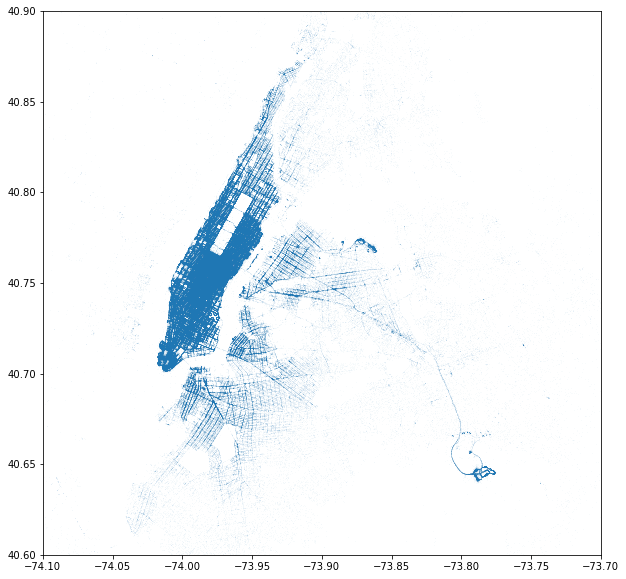

In [18]:
longitude = list(data['pickup_longitude']) + list(data['dropoff_longitude'])
latitude = list(data['pickup_latitude']) + list(data['dropoff_latitude'])

plt.figure(figsize = (10,10))
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05)
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
plt.show()

In [19]:
cx = [c[0] for c in kmeans.cluster_centers_]
cy = [c[1] for c in kmeans.cluster_centers_]

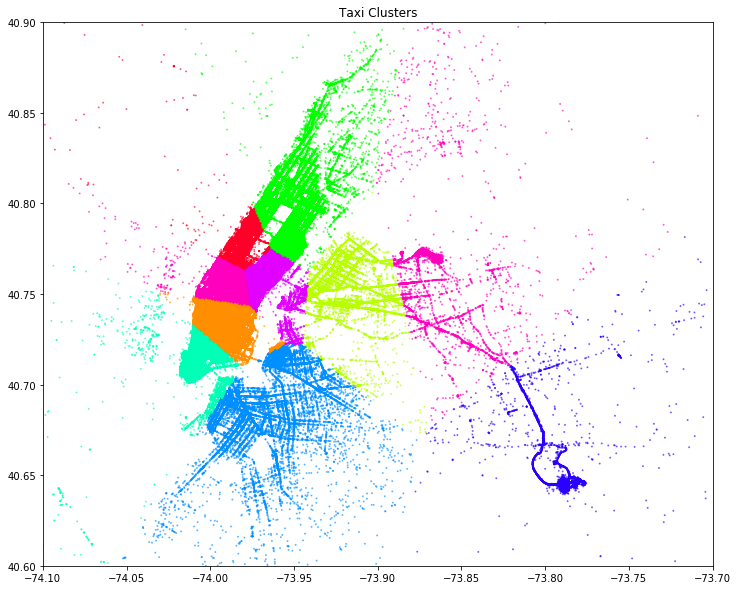

In [60]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)

cm = plt.get_cmap('gist_rainbow')

colors = [cm(2.*i/15) for i in range(10)]
colored = [colors[k] for k in data['pickup_cluster']]

ax.scatter(data.pickup_longitude,data.pickup_latitude,color=colored,s=1,alpha=.5)
#ax.scatter(cx,cy,color='Black',s=50,alpha=1)
plt.title('Taxi Clusters')
plt.show()


In [20]:
data['avg_speed'] = (data['haversine']/(np.exp(data['trip_duration']))) * 3600
data['avg_speed_manhattan'] = (data['manhattan']/(np.exp(data['trip_duration']))) * 3600

x = np.array([[ 40.77048694, -73.95918315],
       [ 40.71787094, -73.99714523],
       [ 40.65233621, -73.7780317 ],
       [ 40.76109215, -73.98152022],
       [ 36.70934105, -99.68704605],
       [ 40.76986234, -73.87194152],
       [ 40.80308751, -73.9571022 ],
       [ 40.67638754, -73.96018755],
       [ 40.69229816, -74.17533706],
       [ 40.74194487, -73.99198258]])

In [21]:
avg_percluster = data.pivot_table(values=["avg_speed"], index=["pickup_cluster","dropoff_cluster"], aggfunc=np.mean)
avg_percluster_manh = data.pivot_table(values=["avg_speed_manhattan"], index=["pickup_cluster","dropoff_cluster"], aggfunc=np.mean)

In [22]:
data['avg_percluster'] = data['avg_speed']
data['avg_percluster_manh'] = data['avg_speed']

for i in range(10):
    for j in range(10):
        data.loc[((data['pickup_cluster'] == i) & (data['dropoff_cluster'] == j)) , 'avg_percluster'] = avg_percluster['avg_speed'][i][j]
        data.loc[((data['pickup_cluster'] == i) & (data['dropoff_cluster'] == j)) , 'avg_percluster_manh'] = avg_percluster_manh['avg_speed_manhattan'][i][j]

In [23]:
data

,dropoff_latitude,dropoff_longitude,id,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,store_and_fwd_flag,trip_duration,vendor_id,...,count_60min,haversine,manhattan,bearing,pickup_cluster,dropoff_cluster,avg_speed,avg_speed_manhattan,avg_percluster,avg_percluster_manh
0,40.765602,-73.964630,id2875421,1,2016-03-14 17:24:55,40.767937,-73.982155,N,6.120297,2,...,567.0,1.498521,2.208255,99.970196,6,9,11.856428,17.471907,13.744119,21.276248
1,40.731152,-73.999481,id2377394,1,2016-06-12 00:43:35,40.738564,-73.980415,N,6.496775,1,...,650.0,1.805507,2.944199,242.846232,0,0,9.803659,15.986598,11.125885,16.367299
2,40.710087,-74.005333,id3858529,1,2016-01-19 11:35:24,40.763939,-73.979027,N,7.661056,2,...,546.0,6.385098,8.913189,200.319835,6,8,10.822201,15.107100,16.690565,23.726369
3,40.706718,-74.012268,id3504673,1,2016-04-06 19:32:31,40.719971,-74.010040,N,6.061457,2,...,776.0,1.485498,1.721302,187.262300,8,8,12.465721,14.444493,11.191776,16.352830
4,40.782520,-73.972923,id2181028,1,2016-03-26 13:30:55,40.793209,-73.973053,N,6.075346,2,...,609.0,1.188588,1.202960,179.473585,2,2,9.836594,9.955533,15.143198,22.562467
5,40.749184,-73.992081,id0801584,6,2016-01-30 22:01:40,40.742195,-73.982857,N,6.093570,2,...,657.0,1.098942,1.802744,315.004404,0,0,8.930458,14.649836,11.125885,16.367299
6,40.765896,-73.957405,id1813257,4,2016-06-17 22:34:59,40.757839,-73.969017,N,5.831882,1,...,703.0,1.326279,2.187046,47.505775,6,9,14.001768,23.089051,13.744119,21.276248
7,40.760559,-73.922470,id1324603,1,2016-05-21 07:54:58,40.797779,-73.969276,N,7.346655,2,...,221.0,5.714981,9.343302,136.385396,2,9,13.264945,21.686582,12.908713,18.879617
8,40.732815,-73.985786,id1301050,1,2016-05-27 23:12:23,40.738400,-73.999481,N,5.541264,1,...,598.0,1.310353,2.143780,118.284067,0,0,18.499105,30.265135,11.125885,16.367299
9,40.789989,-73.973000,id0012891,1,2016-03-10 21:45:01,40.744339,-73.981049,N,7.110696,2,...,763.0,5.121162,5.971111,7.603538,1,2,15.049944,17.547755,17.899119,24.613244


In [24]:
train_data, test_data = data[:1444051], data[1444051:]
print(train_data.shape, test_data.shape)

(1444051, 26) (625134, 26)


In [25]:
y = train_data['trip_duration']
train_data.drop('trip_duration', axis=1, inplace=True)
train_data.drop('id', axis=1, inplace=True)
train_data.drop('pickup_datetime', axis=1, inplace=True)
train_data.drop('avg_speed', axis=1, inplace=True)
train_data.drop('avg_speed_manhattan', axis=1, inplace=True)
train_data.drop('store_and_fwd_flag', axis=1, inplace=True)


test_data.drop('store_and_fwd_flag', axis=1, inplace=True)
test_data.drop('avg_speed', axis=1, inplace=True)
test_data.drop('avg_speed_manhattan', axis=1, inplace=True)
test_data.drop('trip_duration', axis=1, inplace=True)
test_data.drop('id', axis=1, inplace=True)
test_data.drop('pickup_datetime', axis=1, inplace=True)

/home/itachi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/itachi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/itachi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home

In [26]:
data.drop('trip_duration', axis=1, inplace=True)
data.drop('id', axis=1, inplace=True)
data.drop('pickup_datetime', axis=1, inplace=True)
data.drop('avg_speed', axis=1, inplace=True)
data.drop('avg_speed_manhattan', axis=1, inplace=True)
data.drop('store_and_fwd_flag', axis=1, inplace=True)

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6).fit(data)
X2_train = pca.transform(train_data)
X2_test = pca.transform(test_data)

X2_train = pd.DataFrame(X2_train)
X2_test = pd.DataFrame(X2_test)

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

train_data = pd.concat([train_data, X2_train], ignore_index=True, axis=1)
test_data = pd.concat([test_data, X2_test], ignore_index=True, axis=1)

print(X2_train.shape + X2_test.shape)
print(train_data.shape + test_data.shape)

(1444051, 6, 625134, 6)
(1444051, 26, 625134, 26)


In [28]:
train_data

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,40.765602,-73.964630,1,40.767937,-73.982155,2,3,11,0,17,...,6,9,13.744119,21.276248,2.241521,-53.021631,17.103297,-19.760997,-2.402815,2.729943
1,40.731152,-73.999481,1,40.738564,-73.980415,1,6,23,6,0,...,0,0,11.125885,16.367299,-81.114553,89.409061,-9.242322,-11.272761,-5.779688,-9.409158
2,40.710087,-74.005333,1,40.763939,-73.979027,2,1,3,1,11,...,6,8,16.690565,23.726369,22.807724,47.446831,-7.325134,2.254289,5.489801,11.409626
3,40.706718,-74.012268,1,40.719971,-74.010040,2,4,14,2,19,...,8,8,11.191776,16.352830,-207.237061,33.108638,-1.519168,-2.533878,-5.650546,-1.460531
4,40.782520,-73.972923,1,40.793209,-73.973053,2,3,12,5,13,...,2,2,15.143198,22.562467,-40.096860,26.249147,11.800310,-22.622894,-1.614308,1.689505
5,40.749184,-73.992081,6,40.742195,-73.982857,2,1,4,5,22,...,0,0,11.125885,16.367299,-89.123413,161.542130,30.022498,4.395724,-7.008325,9.168716
6,40.765896,-73.957405,4,40.757839,-73.969017,1,6,24,4,22,...,6,9,13.744119,21.276248,-133.467109,-106.254247,10.196973,-28.075865,-1.406984,-11.324305
7,40.760559,-73.922470,1,40.797779,-73.969276,2,5,20,5,7,...,2,9,12.908713,18.879617,348.232403,-14.647012,-7.670854,-36.658323,-0.335595,-4.640182
8,40.732815,-73.985786,1,40.738400,-73.999481,1,5,21,4,23,...,0,0,11.125885,16.367299,-28.962232,-34.847744,12.312608,14.068843,-6.716343,-7.938973
9,40.789989,-73.973000,1,40.744339,-73.981049,2,3,10,3,21,...,1,2,17.899119,24.613244,-193.233446,-146.490096,-27.140398,17.626327,5.505391,2.952747


In [29]:
test_data

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,40.756680,-73.990173,1,40.732029,-73.988129,1,6,26,3,23,...,0,1,11.602519,17.021030,-49.241605,203.153693,-12.298936,-39.103132,-4.281539,-13.135807
1,40.655403,-73.959808,1,40.679993,-73.964203,1,6,26,3,23,...,5,5,14.689787,21.427959,-48.185690,19.008908,-14.612270,-34.716257,-0.003825,-12.982585
2,40.729523,-73.986160,1,40.737583,-73.997437,1,6,26,3,23,...,0,0,11.125885,16.367299,-48.995461,-19.922038,-17.519171,-29.468059,-6.115845,-13.115767
3,40.730469,-73.986427,1,40.771900,-73.956070,2,6,26,3,23,...,9,0,15.405191,24.195123,-49.366092,55.794538,-20.307478,-24.153601,5.456272,-12.856599
4,40.755890,-73.961510,1,40.761475,-73.970215,1,6,26,3,23,...,6,9,13.744119,21.276248,-48.957288,-23.034069,-24.173165,-17.156135,-1.851552,-13.027344
5,40.786549,-73.980515,1,40.749798,-73.991302,1,6,26,3,23,...,0,2,19.491907,27.891926,-47.249541,-140.757886,-25.507535,-14.505210,7.437332,-12.734313
6,40.717003,-73.952072,1,40.741550,-73.978310,1,6,26,3,23,...,1,5,16.931101,22.015961,-48.993755,-12.304478,-32.738384,-1.328507,2.804075,-12.901950
7,40.719509,-73.986481,2,40.701527,-74.012711,1,6,26,3,23,...,8,8,11.191776,16.352830,-47.503171,-105.390662,-35.632209,3.914152,-3.716120,-13.048073
8,40.875214,-73.875618,2,40.730511,-73.992332,2,6,26,3,23,...,0,7,29.832465,43.817036,-47.198831,-121.929952,-12.431164,-35.892617,39.975890,-11.929544
9,40.761311,-73.979309,1,40.748760,-73.993179,2,6,26,3,23,...,0,6,13.126180,19.077242,-46.455028,-113.335089,-17.072258,-28.111775,-2.854139,-13.005421


In [30]:
X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.35)

In [31]:
X_train.columns

RangeIndex(start=0, stop=26, step=1)

In [32]:
start = datetime.datetime.now()

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.grid_search import GridSearchCV

xgb = XGBRegressor(n_estimators=3200,
                   max_depth=9,
                   learning_rate=0.02,
                   min_child_weight=10, 
                   subsample=0.8,
                   colsample_bytree=0.8,
                   reg_alpha=0.005,
                   seed=27
                  )

xgb.fit(X_train, y_train)

end = datetime.datetime.now()
print("Time => " , end-start)

/home/itachi/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Time =>  3:18:27.850056


In [33]:
print(xgb.score(X_train,y_train))
print(xgb.score(X_test,y_test))

0.872709771359
0.806612479646


In [34]:
pred = xgb.predict(test_data)

In [35]:
df_sub = pd.DataFrame({
    'id': test['id'].values,
    'trip_duration': np.exp(pred)}).set_index('id')

In [36]:
df_sub

,trip_duration
id,
id3004672,814.622620
id3505355,594.635742
id1217141,410.988678
id2150126,900.949463
id1598245,359.040192
id0668992,970.182617
id1765014,1147.812500
id0898117,673.012939
id3905224,2407.345947


In [37]:
df_sub

,trip_duration
id,
id3004672,814.622620
id3505355,594.635742
id1217141,410.988678
id2150126,900.949463
id1598245,359.040192
id0668992,970.182617
id1765014,1147.812500
id0898117,673.012939
id3905224,2407.345947


In [38]:
df_sub.to_csv('submission_results.csv')